### Imports

In [1]:
import numpy as np
import pandas as pd
import math
import requests
from numpy import nan
import re
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

### File reading

In [2]:
data = pd.read_csv('./raw_dataset_flats.csv', index_col = 0)
data = data.drop(['Dostępne od', 'Media', 'Obsługa zdalna', 'Typ ogłoszeniodawcy', 'Materiał budynku', 'Ilość pokoi', 'Forma własności', 'Okna'], axis = 1)

In [3]:
data.rename(columns = {'Cena': 'price', 'Cena za metr kwadratowy': 'price_per_square_meter', 'Powierzchnia': 'area', 'Lokalizacja': 'location', 'Liczba pokoi': 'number_of_rooms', 'Stan wykończenia': 'finishing_standard', 'Piętro': 'floor', 'Balkon / ogród / taras': 'balcony/garden/terrace', 'Czynsz': 'rent', 'Miejsce parkingowe': 'parking', 'Ogrzewanie': 'heating', 'Rynek': 'market', 'Rok budowy': 'construction_year', 'Rodzaj zabudowy': 'building_type', 'Winda': 'lift', 'Zabezpieczenia': 'security', 'Wyposażenie': 'furnishings', 'Informacje dodatkowe': 'additional_information'}, inplace=True)

In [4]:
data = data.reset_index(drop = True)

In [5]:
data.head()

,price,price_per_square_meter,area,location,number_of_rooms,finishing_standard,floor,balcony/garden/terrace,rent,parking,heating,market,construction_year,building_type,lift,security,furnishings,additional_information
0,560 000 zł,9887 zł/m2,"56,64 m²","ul. Brylantowa, Dobrzykowice, dolnośląskie",3,do zamieszkania,1/3,balkon,600 zł,garaż/miejsce parkingowe,kotłownia,wtórny,2021,blok,tak,"drzwi / okna antywłamaniowe, domofon / wideofon","zmywarka, lodówka, meble, piekarnik, kuchenka,...",brak informacji
1,950 000 zł,14 175 zł/m2,"67,02 m²","Warszawa, Praga-Południe, ul. Terespolska",3,do zamieszkania,6/6,balkon,610 zł,garaż/miejsce parkingowe,miejskie,wtórny,2012,blok,tak,"teren zamknięty, domofon / wideofon, monitorin...","zmywarka, lodówka, meble, piekarnik, kuchenka,...",oddzielna kuchnia
2,264 900 zł,9811 zł/m2,27 m²,"Katowice, Piotrowice - Ochojec, Ochojec",1,do zamieszkania,5/8,balkon,zapytaj,zapytaj,miejskie,wtórny,1970,blok,tak,monitoring / ochrona,brak informacji,brak informacji
3,464 000 zł,8000 zł/m2,58 m²,"Sosnowiec, Zagórze",3,do zamieszkania,2/3,balkon,350 zł,garaż/miejsce parkingowe,gazowe,wtórny,2020,apartamentowiec,tak,brak informacji,brak informacji,oddzielna kuchnia
4,199 900 zł,5666 zł/m2,"35,28 m²","Sosnowiec, Klimontów",2,do zamieszkania,4/4,balkon,420 zł,zapytaj,miejskie,wtórny,brak informacji,blok,nie,brak informacji,brak informacji,"piwnica, oddzielna kuchnia"


In [6]:
data.describe()

,price,price_per_square_meter,area,location,number_of_rooms,finishing_standard,floor,balcony/garden/terrace,rent,parking,heating,market,construction_year,building_type,lift,security,furnishings,additional_information
count,134257,108527,134257,134257,134146,134146,134146,134146,134146,134146,126972,111923,111923,111923,111923,111923,111923,111923
unique,27548,16787,10097,28672,11,4,312,11,1735,2,8,2,247,9,2,65,118,16
top,Zapytaj o cenę,7500 zł/m2,48 m²,"Rzeszów, podkarpackie",3,do wykończenia,4/4,balkon,zapytaj,garaż/miejsce parkingowe,zapytaj,wtórny,brak informacji,blok,nie,brak informacji,brak informacji,brak informacji
freq,25730,733,1292,1130,50827,57594,8086,73887,89288,76269,59851,65500,24647,52354,58613,53931,85266,53050


In [7]:
def get_address_details(location):
    location = re.sub(r'\w*\.\w*', '', location).strip()
    r = requests.get(f'https://nominatim.openstreetmap.org/search/{location}?format=json&addressdetails=1')
    if(bool(r.json())):
        result = r.json()[0]
        address_details = result['address']
        return {'latitude': result['lat'], 'longtitude': result['lon'], 'city': address_details.get('city', nan), 'state': address_details.get('state', nan), 'village': address_details.get('village', nan), 'town': address_details.get('town', nan), 'road': address_details.get('road', nan), 'city_district': address_details.get('city_district', nan)}


def get_population(locality):
    r = requests.get(f'https://public.opendatasoft.com/api/records/1.0/search/?dataset=geonames-all-cities-with-a-population-1000&q={locality}')
    if(locality.lower() == 'Warszawa'.lower()):
        return 1765000
    if(bool(r.json().get('records'))):
        return r.json().get('records')[0].get('fields').get('population')

In [8]:
def get_time_to_nearest_point(point_type, lat, lon):
    result = requests.get(f'https://nominatim.openstreetmap.org/search.php?q={point_type}+near+{lat},{lon}&format=jsonv2&limit=1').json()
    if(bool(result)):
        point_lat = result[0].get('lat')
        point_lon = result[0].get('lon')
        duration_res = requests.get(f'https://router.project-osrm.org/route/v1/car/{lon},{lat};{point_lon},{point_lat}?overview=false').json()
        if(bool(duration_res and bool(duration_res.get('routes')))):
            duration = duration_res.get('routes')[0].get('duration') 
            return duration / 60 #convert to minutes

def get_time_to_nearest_shop(lat, lon):
    time_to_nearest_supermarket = get_time_to_nearest_point('supermarket', lat, lon)
    time_to_nearest_convenience_shop = get_time_to_nearest_point('convenience_shop', lat, lon)
    
    result = min(time_to_nearest_supermarket or 100000, time_to_nearest_convenience_shop or 100000)
    
    if(result != 100000):
        return result

def get_time_to_nearest_stop(lat, lon):
    time_to_nearest_bus_stop = get_time_to_nearest_point('bus stop', lat, lon)
    time_to_nearest_tram_stop = get_time_to_nearest_point('tram stop', lat, lon)
    
    result = min(time_to_nearest_bus_stop or 100000, time_to_nearest_tram_stop or 100000) 
    
    if(result != 100000):
        return result

def get_time_to_centre(lat, lon, location):
    result = requests.get(f'https://nominatim.openstreetmap.org/search/{location}?format=json&addressdetails=1').json()
    if(bool(result)):
        centre_lat = result[0].get('lat')
        centre_lon = result[0].get('lon')
        duration_res = requests.get(f'https://router.project-osrm.org/route/v1/car/{lon},{lat};{centre_lon},{centre_lat}?overview=false').json()
        if(bool(duration_res) and bool(duration_res.get('routes'))):
            duration = duration_res.get('routes')[0].get('duration')  
            return duration / 60 #convert to minutes

In [9]:
data = data.fillna(nan)
data = data.replace({'zapytaj': nan, "Zapytaj o cenę": nan, "brak informacji": nan})

In [10]:
for index, row in data.iterrows():
    if(data.loc[index, 'price'] is nan or (data.loc[index, 'price'] is not nan and '€' in data.loc[index, 'price'])):
        data = data.drop(index)

In [11]:
data = data.reset_index(drop = True)

In [12]:
for index, row in data.iterrows():
    row = row.copy()
    location = row.location 
    dict_temp = get_address_details(location)
    if(bool(dict_temp)):
        data.loc[index, 'state'] = dict_temp.get('state')

        if(isinstance(dict_temp.get('city'), str)):
            data.loc[index, 'locality'] = dict_temp.get('city')
            data.loc[index, 'population'] = get_population(dict_temp.get('city'))
            data.loc[index, 'type_of_locality'] = 'city'
        if(isinstance(dict_temp.get('village'), str)):
            data.loc[index, 'locality'] = dict_temp.get('village')
            data.loc[index, 'population'] = get_population(dict_temp.get('village'))
            data.loc[index, 'type_of_locality'] = 'village'
        if(isinstance(dict_temp.get('town'), str)):
            data.loc[index, 'locality'] = dict_temp.get('town')
            data.loc[index, 'population'] = get_population(dict_temp.get('town'))
            data.loc[index, 'type_of_locality'] = 'town'

        latitude = dict_temp.get('latitude')
        longtitude = dict_temp.get('longtitude')
        locality = data.iloc[index]['locality']
        data.loc[index, 'time_to_nearest_shop'] = get_time_to_nearest_shop(latitude, longtitude)
        data.loc[index, 'time_to_nearest_stop'] = get_time_to_nearest_stop(latitude, longtitude)
        data.loc[index, 'time_to_centre'] = get_time_to_centre(latitude, longtitude, locality)

In [13]:
data = data.fillna(nan)

In [14]:
data.to_csv('./enriched_dataset_flats.csv')

In [15]:
data = pd.read_csv('./enriched_dataset_flats.csv', index_col = 0)
data.head()

,price,price_per_square_meter,area,location,number_of_rooms,finishing_standard,floor,balcony/garden/terrace,rent,parking,...,security,furnishings,additional_information,state,locality,population,type_of_locality,time_to_nearest_shop,time_to_nearest_stop,time_to_centre
0,560 000 zł,9887 zł/m2,"56,64 m²","ul. Brylantowa, Dobrzykowice, dolnośląskie",3,do zamieszkania,1/3,balkon,600 zł,garaż/miejsce parkingowe,...,"drzwi / okna antywłamaniowe, domofon / wideofon","zmywarka, lodówka, meble, piekarnik, kuchenka,...",NaN,województwo dolnośląskie,Dobrzykowice,NaN,village,5.045000,3.238333,3.256667
1,950 000 zł,14 175 zł/m2,"67,02 m²","Warszawa, Praga-Południe, ul. Terespolska",3,do zamieszkania,6/6,balkon,610 zł,garaż/miejsce parkingowe,...,"teren zamknięty, domofon / wideofon, monitorin...","zmywarka, lodówka, meble, piekarnik, kuchenka,...",oddzielna kuchnia,województwo mazowieckie,Warszawa,1765000.0,city,0.220000,0.246667,9.410000
2,264 900 zł,9811 zł/m2,27 m²,"Katowice, Piotrowice - Ochojec, Ochojec",1,do zamieszkania,5/8,balkon,NaN,NaN,...,monitoring / ochrona,NaN,NaN,województwo śląskie,Katowice,317316.0,city,1.901667,0.180000,12.275000
3,464 000 zł,8000 zł/m2,58 m²,"Sosnowiec, Zagórze",3,do zamieszkania,2/3,balkon,350 zł,garaż/miejsce parkingowe,...,NaN,NaN,oddzielna kuchnia,województwo śląskie,Sosnowiec,227295.0,city,2.395000,3.275000,10.791667
4,199 900 zł,5666 zł/m2,"35,28 m²","Sosnowiec, Klimontów",2,do zamieszkania,4/4,balkon,420 zł,NaN,...,NaN,NaN,"piwnica, oddzielna kuchnia",województwo śląskie,Sosnowiec,227295.0,city,3.190000,1.856667,10.391667


In [16]:
data.columns

Index(['price', 'price_per_square_meter', 'area', 'location',
       'number_of_rooms', 'finishing_standard', 'floor',
       'balcony/garden/terrace', 'rent', 'parking', 'heating', 'market',
       'construction_year', 'building_type', 'lift', 'security', 'furnishings',
       'additional_information', 'state', 'locality', 'population',
       'type_of_locality', 'time_to_nearest_shop', 'time_to_nearest_stop',
       'time_to_centre'],
      dtype='object')

### Categorical columns

In [17]:
categorical_columns_names = ['finishing_standard', 'balcony/garden/terrace', 'parking', 'heating', 'market', 'building_type', 'lift', 'security', 'furnishings', 'additional_information']

In [18]:
for column_name in categorical_columns_names:
    print(column_name)
    print(data[column_name].unique())

finishing_standard
['do zamieszkania' 'do remontu' nan 'do wykończenia']
balcony/garden/terrace
['balkon' 'taras' nan 'ogródek' 'ogródek, taras' 'balkon, ogródek, taras'
 'balkon, taras' 'balkon, ogródek' 'taras, ogródek' 'taras, balkon'
 'taras, balkon, ogródek']
parking
['garaż/miejsce parkingowe' nan]
heating
['kotłownia' 'miejskie' 'gazowe' nan 'inne' 'elektryczne' 'piece kaflowe'
 'tak']
market
['wtórny' nan 'pierwotny']
building_type
['blok' 'apartamentowiec' nan 'kamienica' 'szeregowiec' 'dom wolnostojący'
 'plomba' 'loft' 'bliźniak']
lift
['tak' 'nie' nan]
security
['drzwi / okna antywłamaniowe, domofon / wideofon'
 'teren zamknięty, domofon / wideofon, monitoring / ochrona'
 'monitoring / ochrona' nan
 'drzwi / okna antywłamaniowe, teren zamknięty, domofon / wideofon'
 'domofon / wideofon'
 'teren zamknięty, domofon / wideofon, monitoring / ochrona, rolety antywłamaniowe'
 'system alarmowy, teren zamknięty, domofon / wideofon'
 'drzwi / okna antywłamaniowe, teren zamknięty, do

In [19]:
le_finishing_standard = preprocessing.LabelEncoder()
le_finishing_standard.fit(data['finishing_standard'])
print(list(le_finishing_standard.classes_))
data['finishing_standard'] = le_finishing_standard.fit_transform(data['finishing_standard'])

le_heating = preprocessing.LabelEncoder()
le_heating.fit(data['heating'])
print(list(le_heating.classes_))
data['heating'] = le_heating.fit_transform(data['heating'])

le_building_type = preprocessing.LabelEncoder()
le_building_type.fit(data['building_type'])
print(list(le_building_type.classes_))
data['building_type'] = le_building_type.fit_transform(data['building_type'])

le_market = preprocessing.LabelEncoder()
le_market.fit(data['market'])
print(list(le_market.classes_))
data['market'] = le_market.fit_transform(data['market'])

le_state = preprocessing.LabelEncoder()
le_state.fit(data['state'])
print(list(le_state.classes_))
data['state'] = le_state.fit_transform(data['state'])

le_locality = preprocessing.LabelEncoder()
le_locality.fit(data['locality'])
print(list(le_locality.classes_))
data['locality'] = le_locality.fit_transform(data['locality'])

le_locality_type = preprocessing.LabelEncoder()
le_locality_type.fit(data['type_of_locality'])
print(list(le_locality_type.classes_))
data['type_of_locality'] = le_locality_type.fit_transform(data['type_of_locality'])

['do remontu', 'do wykończenia', 'do zamieszkania', nan]
['elektryczne', 'gazowe', 'inne', 'kotłownia', 'miejskie', 'piece kaflowe', 'tak', nan]
['apartamentowiec', 'bliźniak', 'blok', 'dom wolnostojący', 'kamienica', 'loft', 'plomba', 'szeregowiec', nan]
['pierwotny', 'wtórny', nan]
['Centre-Val de Loire', 'województwo dolnośląskie', 'województwo kujawsko-pomorskie', 'województwo lubelskie', 'województwo lubuskie', 'województwo mazowieckie', 'województwo małopolskie', 'województwo opolskie', 'województwo podkarpackie', 'województwo podlaskie', 'województwo pomorskie', 'województwo warmińsko-mazurskie', 'województwo wielkopolskie', 'województwo zachodniopomorskie', 'województwo łódzkie', 'województwo śląskie', 'województwo świętokrzyskie', nan]
['Adamowizna', 'Adamowo', 'Aleksandria', 'Aleksandrowo', 'Aleksandrów Kujawski', 'Aleksandrów Łódzki', 'Amandów', 'Andrychów', 'Augustów', 'Babia Ława', 'Babimost', 'Baborów', 'Badowo-Dańki', 'Bagna', 'Bakałarzewo', 'Balice', 'Baligród', 'Banie'

['city', 'town', 'village', nan]


In [20]:
data = data.assign(
    has_balkon = data['balcony/garden/terrace'].fillna('nan').apply(lambda x: ('balkon' in x)).astype(int),
    has_garden = data['balcony/garden/terrace'].fillna('nan').apply(lambda x: ('ogródek' in x)).astype(int),
    has_terrace = data['balcony/garden/terrace'].fillna('nan').apply(lambda x: ('taras' in x)).astype(int),
    has_parking = (~data.parking.isna()).astype(int),
    is_furnished = (~data.furnishings.isna()).astype(int),
    has_lift = (data.lift == 'tak').astype(int),
    has_security_protection = (~data.security.isna()).astype(int),
    is_duplex = data['additional_information'].fillna('nan').apply(lambda x: ('dwupoziomowe' in x)).astype(int),
    has_basement = data['additional_information'].fillna('nan').apply(lambda x: ('piwnica' in x)).astype(int))

In [21]:
data.head()

,price,price_per_square_meter,area,location,number_of_rooms,finishing_standard,floor,balcony/garden/terrace,rent,parking,...,time_to_centre,has_balkon,has_garden,has_terrace,has_parking,is_furnished,has_lift,has_security_protection,is_duplex,has_basement
0,560 000 zł,9887 zł/m2,"56,64 m²","ul. Brylantowa, Dobrzykowice, dolnośląskie",3,2,1/3,balkon,600 zł,garaż/miejsce parkingowe,...,3.256667,1,0,0,1,1,1,1,0,0
1,950 000 zł,14 175 zł/m2,"67,02 m²","Warszawa, Praga-Południe, ul. Terespolska",3,2,6/6,balkon,610 zł,garaż/miejsce parkingowe,...,9.410000,1,0,0,1,1,1,1,0,0
2,264 900 zł,9811 zł/m2,27 m²,"Katowice, Piotrowice - Ochojec, Ochojec",1,2,5/8,balkon,NaN,NaN,...,12.275000,1,0,0,0,0,1,1,0,0
3,464 000 zł,8000 zł/m2,58 m²,"Sosnowiec, Zagórze",3,2,2/3,balkon,350 zł,garaż/miejsce parkingowe,...,10.791667,1,0,0,1,0,1,0,0,0
4,199 900 zł,5666 zł/m2,"35,28 m²","Sosnowiec, Klimontów",2,2,4/4,balkon,420 zł,NaN,...,10.391667,1,0,0,0,0,0,0,0,1


### Numerical columns

In [22]:
data = data[data['price'].str.contains("zł", na = False)]
data

,price,price_per_square_meter,area,location,number_of_rooms,finishing_standard,floor,balcony/garden/terrace,rent,parking,...,time_to_centre,has_balkon,has_garden,has_terrace,has_parking,is_furnished,has_lift,has_security_protection,is_duplex,has_basement
0,560 000 zł,9887 zł/m2,"56,64 m²","ul. Brylantowa, Dobrzykowice, dolnośląskie",3,2,1/3,balkon,600 zł,garaż/miejsce parkingowe,...,3.256667,1,0,0,1,1,1,1,0,0
1,950 000 zł,14 175 zł/m2,"67,02 m²","Warszawa, Praga-Południe, ul. Terespolska",3,2,6/6,balkon,610 zł,garaż/miejsce parkingowe,...,9.410000,1,0,0,1,1,1,1,0,0
2,264 900 zł,9811 zł/m2,27 m²,"Katowice, Piotrowice - Ochojec, Ochojec",1,2,5/8,balkon,NaN,NaN,...,12.275000,1,0,0,0,0,1,1,0,0
3,464 000 zł,8000 zł/m2,58 m²,"Sosnowiec, Zagórze",3,2,2/3,balkon,350 zł,garaż/miejsce parkingowe,...,10.791667,1,0,0,1,0,1,0,0,0
4,199 900 zł,5666 zł/m2,"35,28 m²","Sosnowiec, Klimontów",2,2,4/4,balkon,420 zł,NaN,...,10.391667,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108479,325 000 zł,5078 zł/m2,64 m²,"Zabrze, Zaborze, UL. Księdza Pawła Janika 14",3,3,parter/4,balkon,NaN,NaN,...,7.711667,1,0,0,0,0,0,0,0,1
108480,620 000 zł,10 403 zł/m2,"59,6 m²","Warszawa, Żoliborz, ul. Marii Dąbrowskiej 11",3,0,6/11,balkon,770 zł,NaN,...,NaN,1,0,0,0,1,1,1,0,1
108481,63 000 zł,1024 zł/m2,"61,5 m²","Warszawa, Ursynów",3,3,NaN,NaN,NaN,NaN,...,26.983333,0,0,0,0,0,0,0,0,0
108482,150 000 zł,5769 zł/m2,26 m²,"Bełchatów, łódzkie",1,1,2/4,balkon,NaN,NaN,...,0.000000,1,0,0,0,0,0,0,0,1


In [23]:
data_without_m2_value = data[~data["area"].str.contains("m²", na = True)]
data_without_m2_value = data_without_m2_value[~data_without_m2_value["area"].str.contains("m2", na = True)]

data_without_m2_value

,price,price_per_square_meter,area,location,number_of_rooms,finishing_standard,floor,balcony/garden/terrace,rent,parking,...,time_to_centre,has_balkon,has_garden,has_terrace,has_parking,is_furnished,has_lift,has_security_protection,is_duplex,has_basement


In [24]:
data['number_of_floors'] = nan
for index, row in data.iterrows():
    row = row.copy()
    floor_information = row.floor
    if(bool(floor_information) and not isinstance(floor_information, float) and '/' in floor_information):
        floor_information = floor_information.replace('parter', '0').replace('suterena', '-1')
        floor = floor_information[0:floor_information.index('/')]; 
        number_of_floors = floor_information[floor_information.index('/') + 1:]; 
        data.loc[index, 'floor'] = floor
        data.loc[index, 'number_of_floors'] = number_of_floors

In [25]:
float_columns_names = ['price', 'price_per_square_meter', 'area', 'rent']
int_columns_names = ['number_of_rooms', 'floor', 'number_of_floors', 'construction_year']
numerical_columns_names = float_columns_names + int_columns_names
for column_name in numerical_columns_names:
    if column_name in float_columns_names: 
        data[column_name] = data[column_name].str.replace(' ', '').str.replace(',', '.').str.extract('(\d+\.*\d+)').astype(float)
    else: 
        data[column_name] = pd.to_numeric(data[column_name], errors='coerce').convert_dtypes()

In [26]:
numerical_columns_names = numerical_columns_names + ['time_to_nearest_shop', 'time_to_nearest_stop', 'time_to_centre']
for column_name in numerical_columns_names:
    data[column_name].fillna(math.floor(data[column_name].median()), inplace=True)

In [27]:
data

,price,price_per_square_meter,area,location,number_of_rooms,finishing_standard,floor,balcony/garden/terrace,rent,parking,...,has_balkon,has_garden,has_terrace,has_parking,is_furnished,has_lift,has_security_protection,is_duplex,has_basement,number_of_floors
0,560000.0,9887.0,56.64,"ul. Brylantowa, Dobrzykowice, dolnośląskie",3,2,1,balkon,600.0,garaż/miejsce parkingowe,...,1,0,0,1,1,1,1,0,0,3
1,950000.0,14175.0,67.02,"Warszawa, Praga-Południe, ul. Terespolska",3,2,6,balkon,610.0,garaż/miejsce parkingowe,...,1,0,0,1,1,1,1,0,0,6
2,264900.0,9811.0,27.00,"Katowice, Piotrowice - Ochojec, Ochojec",1,2,5,balkon,460.0,NaN,...,1,0,0,0,0,1,1,0,0,8
3,464000.0,8000.0,58.00,"Sosnowiec, Zagórze",3,2,2,balkon,350.0,garaż/miejsce parkingowe,...,1,0,0,1,0,1,0,0,0,3
4,199900.0,5666.0,35.28,"Sosnowiec, Klimontów",2,2,4,balkon,420.0,NaN,...,1,0,0,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108479,325000.0,5078.0,64.00,"Zabrze, Zaborze, UL. Księdza Pawła Janika 14",3,3,0,balkon,460.0,NaN,...,1,0,0,0,0,0,0,0,1,4
108480,620000.0,10403.0,59.60,"Warszawa, Żoliborz, ul. Marii Dąbrowskiej 11",3,0,6,balkon,770.0,NaN,...,1,0,0,0,1,1,1,0,1,11
108481,63000.0,1024.0,61.50,"Warszawa, Ursynów",3,3,2,NaN,460.0,NaN,...,0,0,0,0,0,0,0,0,0,4
108482,150000.0,5769.0,26.00,"Bełchatów, łódzkie",1,1,2,balkon,460.0,NaN,...,1,0,0,0,0,0,0,0,1,4


In [28]:
data.dtypes

price                      float64
price_per_square_meter     float64
area                       float64
location                    object
number_of_rooms              Int64
finishing_standard           int64
floor                        Int64
balcony/garden/terrace      object
rent                       float64
parking                     object
heating                      int64
market                       int64
construction_year            Int64
building_type                int64
lift                        object
security                    object
furnishings                 object
additional_information      object
state                        int64
locality                     int64
population                 float64
type_of_locality             int64
time_to_nearest_shop       float64
time_to_nearest_stop       float64
time_to_centre             float64
has_balkon                   int64
has_garden                   int64
has_terrace                  int64
has_parking         

#### Price

<AxesSubplot:ylabel='Frequency'>

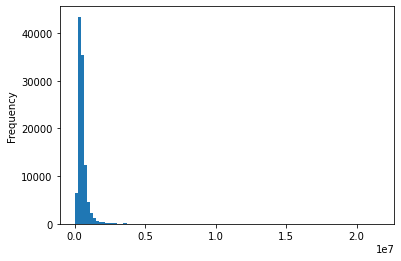

In [29]:
data.price.plot.hist(bins = 100)

In [30]:
data = data[data.price > 20_000]

#### Price per square meter

<AxesSubplot:ylabel='Frequency'>

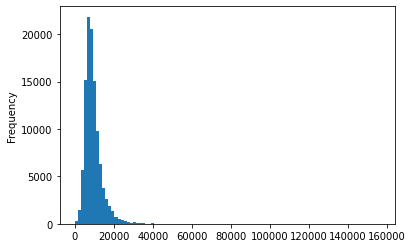

In [31]:
data.price_per_square_meter.plot.hist(bins = 100)

In [32]:
data = data[data.price_per_square_meter > 1_000][data.price_per_square_meter < 70_000]

#### Area

<AxesSubplot:ylabel='Frequency'>

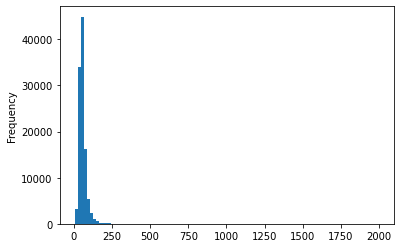

In [33]:
data.area.plot.hist(bins = 100)

In [34]:
data = data[data.area > 10][data.area < 350]

#### Rent

<AxesSubplot:ylabel='Frequency'>

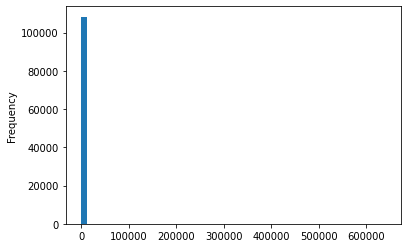

In [35]:
data.rent.plot.hist(bins = 50)

In [36]:
data = data[data.rent < 10000]

#### Number of rooms

<AxesSubplot:ylabel='Frequency'>

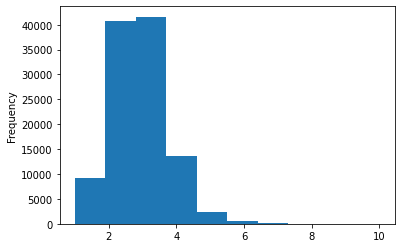

In [37]:
data.number_of_rooms.plot.hist(bins = 10)

#### Floor

<AxesSubplot:ylabel='Frequency'>

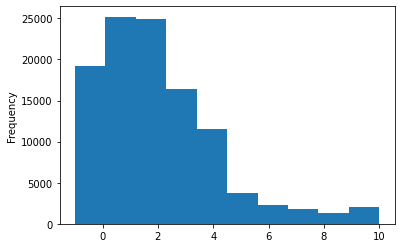

In [38]:
data.floor.plot.hist(bins = 10)

#### Number of floors

<AxesSubplot:ylabel='Frequency'>

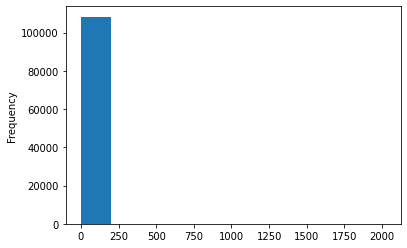

In [39]:
data.number_of_floors.plot.hist(bins = 10)

#### Construction year

<AxesSubplot:ylabel='Frequency'>

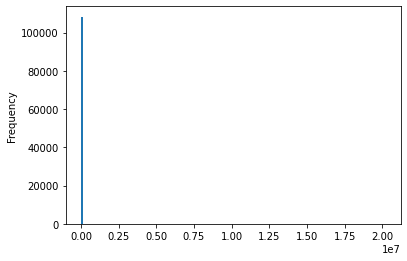

In [40]:
data.construction_year.plot.hist(bins = 150)

In [41]:
data = data[data.construction_year > 1800][data.construction_year < 2030]

#### Time to centre

<AxesSubplot:ylabel='Frequency'>

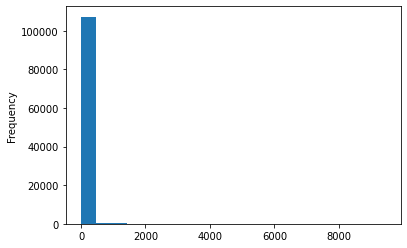

In [42]:
data.time_to_centre.plot.hist(bins = 20)

In [43]:
data = data[data.time_to_centre < 60]

#### Time to the nearest shop

<AxesSubplot:ylabel='Frequency'>

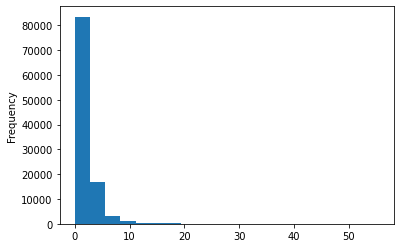

In [44]:
data.time_to_nearest_shop.plot.hist(bins = 20)

In [45]:
data = data[data.time_to_nearest_shop < 60]

#### Time to the nearest shop

<AxesSubplot:ylabel='Frequency'>

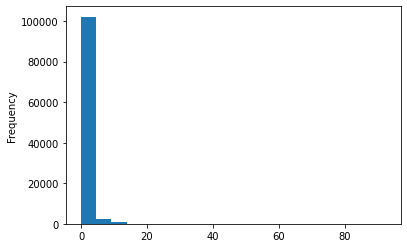

In [46]:
data.time_to_nearest_stop.plot.hist(bins = 20)

In [47]:
data = data[data.time_to_nearest_shop < 60]

In [48]:
data

,price,price_per_square_meter,area,location,number_of_rooms,finishing_standard,floor,balcony/garden/terrace,rent,parking,...,has_balkon,has_garden,has_terrace,has_parking,is_furnished,has_lift,has_security_protection,is_duplex,has_basement,number_of_floors
0,560000.0,9887.0,56.64,"ul. Brylantowa, Dobrzykowice, dolnośląskie",3,2,1,balkon,600.0,garaż/miejsce parkingowe,...,1,0,0,1,1,1,1,0,0,3
1,950000.0,14175.0,67.02,"Warszawa, Praga-Południe, ul. Terespolska",3,2,6,balkon,610.0,garaż/miejsce parkingowe,...,1,0,0,1,1,1,1,0,0,6
2,264900.0,9811.0,27.00,"Katowice, Piotrowice - Ochojec, Ochojec",1,2,5,balkon,460.0,NaN,...,1,0,0,0,0,1,1,0,0,8
3,464000.0,8000.0,58.00,"Sosnowiec, Zagórze",3,2,2,balkon,350.0,garaż/miejsce parkingowe,...,1,0,0,1,0,1,0,0,0,3
4,199900.0,5666.0,35.28,"Sosnowiec, Klimontów",2,2,4,balkon,420.0,NaN,...,1,0,0,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108479,325000.0,5078.0,64.00,"Zabrze, Zaborze, UL. Księdza Pawła Janika 14",3,3,0,balkon,460.0,NaN,...,1,0,0,0,0,0,0,0,1,4
108480,620000.0,10403.0,59.60,"Warszawa, Żoliborz, ul. Marii Dąbrowskiej 11",3,0,6,balkon,770.0,NaN,...,1,0,0,0,1,1,1,0,1,11
108481,63000.0,1024.0,61.50,"Warszawa, Ursynów",3,3,2,NaN,460.0,NaN,...,0,0,0,0,0,0,0,0,0,4
108482,150000.0,5769.0,26.00,"Bełchatów, łódzkie",1,1,2,balkon,460.0,NaN,...,1,0,0,0,0,0,0,0,1,4


#### Population

<AxesSubplot:ylabel='Frequency'>

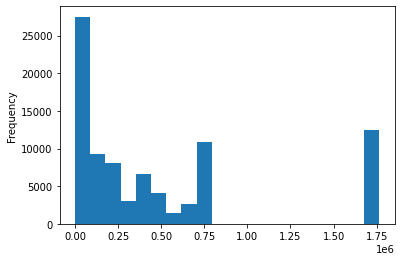

In [49]:
data.population.plot.hist(bins = 20)


In [50]:
data = data[data.population > 0]

In [51]:
data = data.assign(age = 2022 - data.construction_year)

#### Normalization

In [52]:
rent_scaler = preprocessing.MinMaxScaler()
rent_scaler.fit(data[['rent']].to_numpy())
data['rent'] = rent_scaler.fit_transform(data[['rent']].to_numpy())

population_scaler = preprocessing.MinMaxScaler()
population_scaler.fit(data[['population']].to_numpy())
data[['population']] = population_scaler.fit_transform(data[['population']].to_numpy())

age_scaler = preprocessing.MinMaxScaler()
age_scaler.fit(data[['age']].to_numpy())
data['age'] = age_scaler.fit_transform(data[['age']].to_numpy())

area_scaler = preprocessing.MinMaxScaler()
area_scaler.fit(data[['area']].to_numpy())
data[['area']] = area_scaler.fit_transform(data[['area']].to_numpy())

In [53]:
data

,price,price_per_square_meter,area,location,number_of_rooms,finishing_standard,floor,balcony/garden/terrace,rent,parking,...,has_garden,has_terrace,has_parking,is_furnished,has_lift,has_security_protection,is_duplex,has_basement,number_of_floors,age
1,950000.0,14175.0,0.170840,"Warszawa, Praga-Południe, ul. Terespolska",3,2,6,balkon,0.067777,garaż/miejsce parkingowe,...,0,0,1,1,1,1,0,0,6,0.060465
2,264900.0,9811.0,0.050406,"Katowice, Piotrowice - Ochojec, Ochojec",1,2,5,balkon,0.051110,NaN,...,0,0,0,0,1,1,0,0,8,0.255814
3,464000.0,8000.0,0.143695,"Sosnowiec, Zagórze",3,2,2,balkon,0.038888,garaż/miejsce parkingowe,...,0,0,1,0,1,0,0,0,3,0.023256
4,199900.0,5666.0,0.075324,"Sosnowiec, Klimontów",2,2,4,balkon,0.046666,NaN,...,0,0,0,0,0,0,0,1,4,0.032558
5,299000.0,6229.0,0.113602,"Sosnowiec, Centrum",3,2,5,balkon,0.074443,NaN,...,0,0,0,0,1,0,0,1,10,0.032558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108476,135000.0,3857.0,0.074481,"Włocławek, Centrum",1,2,1,NaN,0.051110,NaN,...,0,0,0,0,0,0,0,0,1,0.032558
108479,325000.0,5078.0,0.161751,"Zabrze, Zaborze, UL. Księdza Pawła Janika 14",3,3,0,balkon,0.051110,NaN,...,0,0,0,0,0,0,0,1,4,0.032558
108481,63000.0,1024.0,0.154228,"Warszawa, Ursynów",3,3,2,NaN,0.051110,NaN,...,0,0,0,0,0,0,0,0,4,0.032558
108482,150000.0,5769.0,0.047397,"Bełchatów, łódzkie",1,1,2,balkon,0.051110,NaN,...,0,0,0,0,0,0,0,1,4,0.032558


In [54]:
data.columns

Index(['price', 'price_per_square_meter', 'area', 'location',
       'number_of_rooms', 'finishing_standard', 'floor',
       'balcony/garden/terrace', 'rent', 'parking', 'heating', 'market',
       'construction_year', 'building_type', 'lift', 'security', 'furnishings',
       'additional_information', 'state', 'locality', 'population',
       'type_of_locality', 'time_to_nearest_shop', 'time_to_nearest_stop',
       'time_to_centre', 'has_balkon', 'has_garden', 'has_terrace',
       'has_parking', 'is_furnished', 'has_lift', 'has_security_protection',
       'is_duplex', 'has_basement', 'number_of_floors', 'age'],
      dtype='object')

In [55]:
data = data.reset_index(drop = True)

In [56]:
data.head()

,price,price_per_square_meter,area,location,number_of_rooms,finishing_standard,floor,balcony/garden/terrace,rent,parking,...,has_garden,has_terrace,has_parking,is_furnished,has_lift,has_security_protection,is_duplex,has_basement,number_of_floors,age
0,950000.0,14175.0,0.170840,"Warszawa, Praga-Południe, ul. Terespolska",3,2,6,balkon,0.067777,garaż/miejsce parkingowe,...,0,0,1,1,1,1,0,0,6,0.060465
1,264900.0,9811.0,0.050406,"Katowice, Piotrowice - Ochojec, Ochojec",1,2,5,balkon,0.051110,NaN,...,0,0,0,0,1,1,0,0,8,0.255814
2,464000.0,8000.0,0.143695,"Sosnowiec, Zagórze",3,2,2,balkon,0.038888,garaż/miejsce parkingowe,...,0,0,1,0,1,0,0,0,3,0.023256
3,199900.0,5666.0,0.075324,"Sosnowiec, Klimontów",2,2,4,balkon,0.046666,NaN,...,0,0,0,0,0,0,0,1,4,0.032558
4,299000.0,6229.0,0.113602,"Sosnowiec, Centrum",3,2,5,balkon,0.074443,NaN,...,0,0,0,0,1,0,0,1,10,0.032558


In [57]:
columns_to_drop = [
    'balcony/garden/terrace',
    'parking',
    'lift',
    'additional_information',
    'security',
    'location',
    'furnishings',
    'construction_year'
]
data = data.drop(columns=columns_to_drop)


In [58]:
data.describe()

,price,price_per_square_meter,area,number_of_rooms,finishing_standard,floor,rent,heating,market,building_type,...,has_garden,has_terrace,has_parking,is_furnished,has_lift,has_security_protection,is_duplex,has_basement,number_of_floors,age
count,8.573900e+04,85739.000000,85739.000000,85739.000000,85739.000000,85739.000000,85739.000000,85739.000000,85739.000000,85739.000000,...,85739.000000,85739.000000,85739.000000,85739.000000,85739.000000,85739.000000,85739.000000,85739.000000,85739.000000,85739.000000
mean,5.526296e+05,9377.469681,0.146054,2.654206,1.788369,2.280642,0.052836,4.732980,0.725213,3.340918,...,0.105705,0.111746,0.461214,0.251391,0.406140,0.486500,0.025496,0.385845,4.631265,0.092488
std,4.891623e+05,4596.908880,0.076860,0.950401,0.922610,2.003173,0.019064,2.066521,0.539901,2.805570,...,0.307461,0.315056,0.498496,0.433815,0.491114,0.499821,0.157627,0.486797,9.848423,0.126239
min,2.700000e+04,1014.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,3.312670e+05,6485.000000,0.100120,2.000000,1.000000,1.000000,0.051110,4.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.013953
50%,4.490000e+05,8300.000000,0.131658,3.000000,2.000000,2.000000,0.051110,4.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.032558
75%,6.150000e+05,11084.000000,0.170478,3.000000,3.000000,3.000000,0.051110,7.000000,1.000000,4.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,5.000000,0.116279
max,1.400000e+07,68807.000000,1.000000,10.000000,3.000000,10.000000,1.000000,7.000000,2.000000,8.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1980.000000,1.000000


In [59]:
data.dtypes

price                      float64
price_per_square_meter     float64
area                       float64
number_of_rooms              Int64
finishing_standard           int64
floor                        Int64
rent                       float64
heating                      int64
market                       int64
building_type                int64
state                        int64
locality                     int64
population                 float64
type_of_locality             int64
time_to_nearest_shop       float64
time_to_nearest_stop       float64
time_to_centre             float64
has_balkon                   int64
has_garden                   int64
has_terrace                  int64
has_parking                  int64
is_furnished                 int64
has_lift                     int64
has_security_protection      int64
is_duplex                    int64
has_basement                 int64
number_of_floors             Int64
age                        float64
dtype: object

In [60]:
data.isna().sum()

price                      0
price_per_square_meter     0
area                       0
number_of_rooms            0
finishing_standard         0
floor                      0
rent                       0
heating                    0
market                     0
building_type              0
state                      0
locality                   0
population                 0
type_of_locality           0
time_to_nearest_shop       0
time_to_nearest_stop       0
time_to_centre             0
has_balkon                 0
has_garden                 0
has_terrace                0
has_parking                0
is_furnished               0
has_lift                   0
has_security_protection    0
is_duplex                  0
has_basement               0
number_of_floors           0
age                        0
dtype: int64

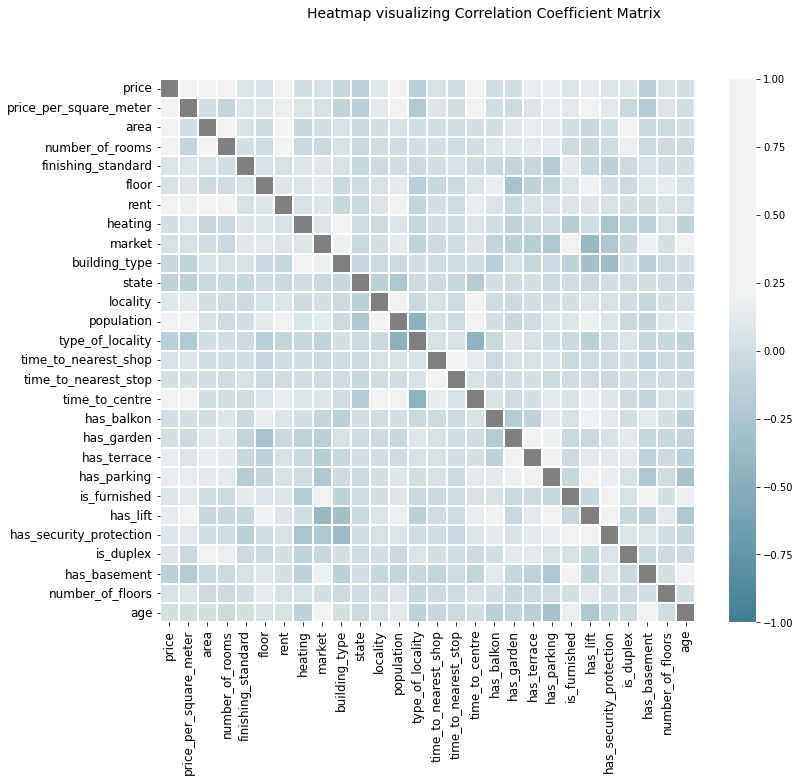

In [61]:
corr = data.corr()
  
masking = np.zeros_like(corr, dtype = np.bool)  
np.fill_diagonal(masking, val = True)  
  
figure, axis = plt.subplots(figsize = (12, 10))  
  
c_map = sns.diverging_palette(223, 14, as_cmap = True, sep = 100)  
c_map.set_bad('grey')  
  
sns.heatmap(corr, mask = masking, cmap = c_map, vmin = -1, vmax = 1, center = 1, linewidths = 1)  
figure.suptitle('Heatmap visualizing Correlation Coefficient Matrix', fontsize = 14)  
axis.tick_params(axis = 'both', which = 'major', labelsize = 12)  

In [62]:
data.to_csv('./preprocessed_dataset_flats.csv')

In [63]:
joblib.dump(rent_scaler, "rent_scaler_flats.save") 

joblib.dump(population_scaler, "population_scaler_flats.save")

joblib.dump(age_scaler, "age_scaler_flats.save")

joblib.dump(age_scaler, "area_scaler_flats.save")

joblib.dump(le_finishing_standard, "le_finishing_standard_flats.save")

joblib.dump(le_heating, "le_heating_flats.save")

joblib.dump(le_building_type, "le_building_type_flats.save")

joblib.dump(le_market, "le_market_flats.save")

joblib.dump(le_state, "le_state_flats.save")

joblib.dump(le_locality, "le_locality_flats.save")

joblib.dump(le_locality, "le_locality_flats.save")

joblib.dump(le_locality_type, "le_locality_type_flats.save")

['le_locality_type_flats.save']